In [46]:
import pandas as pd
from ada2023.utils import *
import matplotlib.pyplot as plt
import numpy as np
import gzip

In [132]:
with gzip.open('../data/wiki-RfA.txt.gz', 'rt', encoding='utf-8') as f:
        blocks = f.read().strip().split('\n\n')  # Assuming each record is separated by a blank line

data = []

# Parse each block of text into a dictionary
for block in blocks:
    record = {}
    for line in block.split('\n'):
        if line:
            key, value = line.split(':', 1)  # Split on the first colon only
            record[key.strip()] = value.strip()
    data.append(record)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

#Rename the columns
df.columns = ['source', 'target', 'vote', 'result', 'year', 'date', 'comment']

#Convert the year, the vote and the result to numeric values
df['year'] = df['year'].astype(int)
df['vote'] = df['vote'].astype(int)
df['result'] = df['result'].astype(int)

df = df[df.year < 2009]


admin_set = set(df['source'].to_list() + df['target'].to_list())

In [133]:
G = create_interaction_graph()

In [134]:
len(admin_set)

8729

In [135]:
G1 = create_interaction_graph()

for node in admin_set:
    # Check if the node is not already in the graph
    if node not in G1.nodes:
        # Add the node to the graph
        G1.add_node(node)

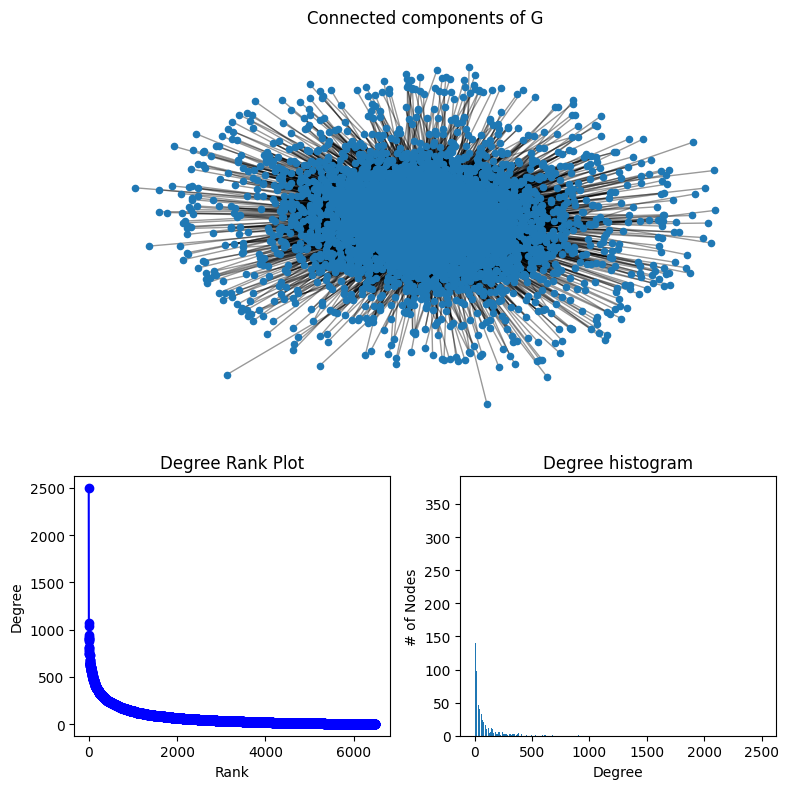

In [170]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [136]:
communities = nx.community.louvain_communities(G)

In [137]:
communities1 = nx.community.louvain_communities(G1)

In [138]:
print(len(communities))
print(len(communities1))

15
2732


In [156]:
n = len(G)
p_same_cluster = 0 # Probability that a random vote is an intra-cluster vote
array_p_same_cluster = np.array([])
for c in communities:
    p_same_cluster += (len(c)/n)*((len(c)-1)/n)
    array_p_same_cluster = np.append(array_p_same_cluster, (len(c)/n)*((len(c)-1)/n))
print(p_same_cluster)

0.15338636165724506


In [157]:
n = len(G1)
p_same_cluster1 = 0 # Probability that a random vote is an intra-cluster vote
array_p_same_cluster1 = np.array([])
for c in communities1:
    p_same_cluster1 += (len(c)/n)*((len(c)-1)/n)
    array_p_same_cluster1 = np.append(array_p_same_cluster1, (len(c)/n)*((len(c)-1)/n))
print(p_same_cluster1)

0.07855854388696869


In [193]:
# Initialize a counter for votes within the same community
effective_intra_vote_count = np.zeros(len(communities))

# Iterate through the dataframe
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']

    # Check if entities are in the same community
    for count, community in enumerate(communities):
        if entity1 in community and entity2 in community:
            effective_intra_vote_count[count] += 1

# Print the result
effective_intra_vote_count.sum()

34102.0

In [194]:
# Initialize a counter for votes within the same community
intra_vote_count1 = np.zeros(len(communities1))

# Iterate through the dataframe
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']

    # Check if entities are in the same community
    for count, community in enumerate(communities1):
        if entity1 in community and entity2 in community:
            intra_vote_count1[count] += 1

# Print the result
intra_vote_count1.sum()

34933.0

In [195]:
# Create a function to check if entities are in the graph
def are_entities_in_same_community(entity1, entity2):
    for community in communities:
        if entity1 in community:
            for c in communities:
                if entity2 in c:
                    return True
            return False
    return False

# Initialize a counter for votes in the graph
votes_in_the_graph = 0

# Iterate through the dataframe
for index, row in df.iterrows():
    entity1 = row['source']
    entity2 = row['target']

    # Check if entities are in the graph
    if entity1 in G and entity2 in G:
        votes_in_the_graph += 1

# Print the result
print(f"Number of votes within the same community: {votes_in_the_graph}")

Number of votes within the same community: 80589


In [196]:
print("Expected percentage of intra-cluster votes in G:", p_same_cluster * 100)
print("Effective percentage of intra-cluster votes in G:", (intra_vote_count.sum()/same_community_vote_count)*100)

Expected percentage of intra-cluster votes in G: 15.338636165724505
Effective percentage of intra-cluster votes in G: 42.315948826762956


In [197]:
print("Expected percentage of intra-cluster votes in G1:", p_same_cluster1 * 100)
print("Effective percentage of intra-cluster votes in G1:", (intra_vote_count1.sum()/len(df))*100)

Expected percentage of intra-cluster votes in G1: 7.855854388696868
Effective percentage of intra-cluster votes in G1: 24.203896679784933


In [198]:
print(len(G))
print(len(admin_set))

6491
8729


In [199]:
expected_nb_votes = array_p_same_cluster * votes_in_the_graph

In [200]:
array_p_same_cluster

array([1.42405916e-07, 1.39572038e-03, 1.41883761e-03, 1.46250876e-04,
       2.24422230e-03, 3.09805495e-02, 5.06960789e-02, 5.40807827e-02,
       6.19038518e-04, 8.75929297e-03, 2.39716626e-04, 5.30462038e-04,
       1.40725526e-03, 5.13135985e-05, 8.16697929e-04])

In [201]:
effective_intra_vote_count

array([    0.,   159.,   230.,    54.,   324.,  8045., 10389., 13567.,
         244.,   430.,    16.,   174.,   313.,    30.,   127.])

In [202]:
effective_intra_vote_count / expected_nb_votes

array([0.        , 1.41358828, 2.01149694, 4.58162476, 1.79144455,
       3.22226434, 2.54286679, 3.11289943, 4.89098563, 0.60914914,
       0.82822066, 4.07023207, 2.75991489, 7.2545924 , 1.92959649])

In [203]:
for c in communities:
    print(len(c))


3
243
245
79
308
1143
1462
1510
162
608
101
150
244
47
186
